In [59]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd
import pandas as pd
from folium.plugins import MarkerCluster
from folium.map import FeatureGroup
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import rcParams
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import collections 
from elasticsearch import Elasticsearch
import matplotlib.cm as cm

In [104]:
# Function for displaying the map
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='800px')

In [105]:
states_shape = gpd.read_file("/data/mus824/Jupyter/states.shp")

In [227]:
states = states_shape[["STATE_NAME", "geometry"]].set_index("STATE_NAME")

In [228]:
df = pd.read_csv('/data/mus824/Jupyter/Base.csv')
# df = pd.read_csv('/data/mus824/Jupyter/PovertyEstimates.csv')
# df = pd.read_csv('/data/szr207/projects/hack19/Base.csv')


In [231]:
income = {}
population = {}
std = {}
crime = {}
school = {}
for i, row in df.iterrows():
    income[row[0]] = row[1]
    population[row[0]] = row[2]
    std[row[0]] = row[3]
    crime[row[0]] = row[1]
    school[row[0]] = row[5]

# Please Enter Query

In [240]:
query = "Police brutality"

In [241]:
es = Elasticsearch()

res = es.search(index="twitter_index", body={"query": {        "match" : {
            "tweet" : {
                "query" : query
            }
        }
}}, size=10000)


lat_long_pos = []
lat_long_neg = []
lat_long_neu = []
for i in res['hits']['hits']:
    if i['_source']['sent'] > 0:
        lat_long_pos.append(i['_source']['lat_long'])
    elif i['_source']['sent'] < 0:
        lat_long_neg.append(i['_source']['lat_long'])
    else:
        lat_long_neu.append(i['_source']['lat_long'])
docs = []
for hit in res['hits']['hits']:
    docs.append(hit["_source"]['tweet'])
m = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=4)

# Add a heatmap to the base map

colors_legend = ['OrRd', 'PuRd', 'RdPu', 'YlGn', 'YlOrBr', 'YlOrRd']

Choropleth(geo_data=states, 
           data=crime, 
           key_on="feature.id", 
           fill_color=colors_legend[0],
           legend_name='Crime',
           fill_opacity='1',
           line_opacity='0.1',
           name='crime',
           show=False
          ).add_to(m)

Choropleth(geo_data=states, 
           data=std, 
           key_on="feature.id", 
           fill_color=colors_legend[1],
           legend_name='std',
           fill_opacity='1',
           line_opacity='0.1',
           name='std',
           show=False
          ).add_to(m)

Choropleth(geo_data=states, 
           data=income, 
           key_on="feature.id", 
           fill_color=colors_legend[2],
           legend_name='income',
           fill_opacity='1',
           line_opacity='0.1',
           name='income',
           show=False
          ).add_to(m)

Choropleth(geo_data=states, 
           data=school, 
           key_on="feature.id", 
           fill_color=colors_legend[3],
           legend_name='school',
           fill_opacity='1',
           line_opacity='0.1',
           name='school',
           show=False
          ).add_to(m)

Choropleth(geo_data=states, 
           data=population, 
           key_on="feature.id", 
           fill_color=colors_legend[4],
           legend_name='population',
           fill_opacity='1',
           line_opacity='0.1',
           name='population',
           show=False
          ).add_to(m)


def stylefunc(feat):
    obj={'weight':1}
    props = feat['properties']
    growth=float(props['growth_10-13'].replace('%',''))
    obj['fillColor']='green' if growth > 0 else 'red'
    obj['color']='black'
    obj['fillOpacity']=0.5
    obj['radius']=(np.log2(props['population'])**4)/3
    return obj

folium.GeoJson(data=states_shape,
               name='states',smooth_factor=2, show=False,
               style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0},
                tooltip=folium.GeoJsonTooltip(fields=['STATE_NAME'], labels=False, sticky=False),
                              highlight_function=lambda x: {'weight':3,'fillColor':'grey'}
              ).add_to(m)

fg_pos = FeatureGroup(name='positive sentiment', show=False).add_to(m)
fg_neg = FeatureGroup(name='negative sentiment', show=False).add_to(m)

for i in lat_long_neg:
    Circle(
        location=i,
        radius=20000,
        color='#d62728',
        fill_color='#d62728',
        opacity=0.5).add_to(fg_neg)
for i in lat_long_pos:
    Circle(
        location=i,
        radius=20000,
        color='#1167b1',
                fill_color='#1167b1',
    opacity=0.5).add_to(fg_pos)
    
folium.LayerControl(autoZIndex=True).add_to(m)
# Display the map
print("Got %d Hits:" % res['hits']['total']['value'])
embed_map(m, 'm.html')

Got 5292 Hits:


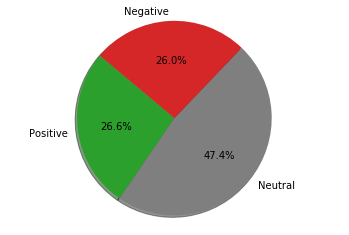

In [237]:
import plotly.graph_objects as go
labels = ['Positive','Neutral','Negative']
values = [len(lat_long_pos), len(lat_long_neu),len(lat_long_neg)]
colors = [ '#2ca02c',"#7f7f7f","#d62728"]
# fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
plt.pie(values, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()


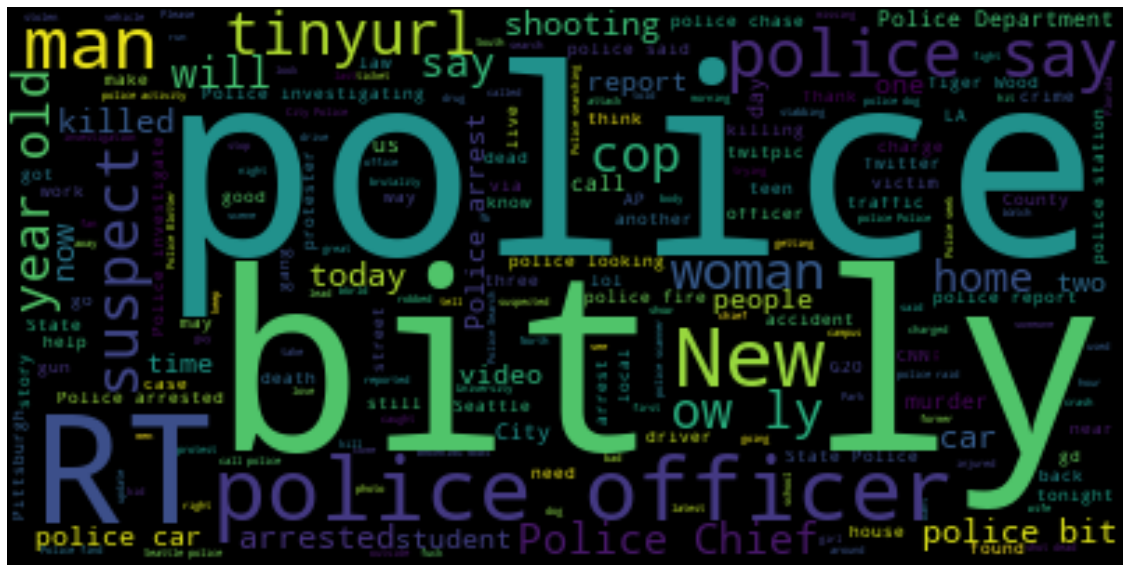

In [238]:
%matplotlib inline
stopwords = STOPWORDS
wordcloud = WordCloud().generate(" ".join(docs))
plt.figure(figsize = (20, 20), facecolor = "white") 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [239]:
m = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=4)

# Add a heatmap to the base map

Choropleth(geo_data=states, 
           data=crime, 
           key_on="feature.id", 
           fill_color='BuGn',
           legend_name='Crime',
           fill_opacity='1',
           line_opacity='0.1',
          ).add_to(m)
#folium.CircleMarker(location=lat_long_pos, popup='The Waterfront', tooltip="America Fuck Yeah").add_to(m)

marker_cluster = MarkerCluster().add_to(m)

def stylefunc(feat):
    obj={'weight':1}
    props = feat['properties']
    growth=float(props['growth_10-13'].replace('%',''))
    obj['fillColor']='green' if growth > 0 else 'red'
    obj['color']='black'
    obj['fillOpacity']=0.5
    obj['radius']=(np.log2(props['population'])**4)/3
    return obj

folium.GeoJson(data=states_shape,
               name='US States',smooth_factor=2,
               style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0},
                tooltip=folium.GeoJsonTooltip(fields=['STATE_NAME'], labels=False, sticky=False),
                              highlight_function=lambda x: {'weight':3,'fillColor':'grey'}
              ).add_to(m)

#HeatMap(data=lat_long_neg, radius=12, gradient={.4: 'pink', .65: 'orange', 1: 'red'}, blur=1).add_to(m)
#HeatMap(data=lat_long_pos, radius=12, gradient={.4: 'beige', .65: 'blue', 1: 'darkblue'}, blur=1).add_to(m)
for i in lat_long_pos:
    Circle(
        location=i,
        radius=40,
        color='green').add_to(marker_cluster)
for i in lat_long_neg:
    Circle(
        location=i,
        radius=40,
        color='red').add_to(marker_cluster)

    
# folium.GeoJson(uscities, 
#                name='Top US Cities by Population',
#                marker=folium.Circle(location=None, fill=True, radius=False, fill_opacity=0.5), 
#                style_function=stylefunc,
#                highlight_function=lambda x: {"weight":3,'fillOpacity':0.95,'zoom':8}
#               ).add_to(m)



folium.LayerControl(autoZIndex=True).add_to(m)
# Display the map
embed_map(m, 'm.html')